In [2]:
import xarray as xr 
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 


In [125]:

def workability_functions(wbgt, intensity="moderate", loss_function="HOTHAPS"):
    """
    Compute workability loss based on WBGT (Wet-Bulb Globe Temperature) and work intensity.

    Parameters:
        wbgt (float or np.ndarray): Wet-Bulb Globe Temperature in ºC.
        intensity (str, optional): Work intensity level. Options: "low", "moderate", "high".
                                   - "low" = 200W (office work)
                                   - "moderate" = 300W (manufacturing)
                                   - "high" = 400W (construction/agriculture)
        loss_function (str, optional): Method used to compute loss. Currently supports "HOTHAPS", "ISO", and "NIOSH"

    Returns:
        float or np.ndarray: Workability loss as a fraction (0 to 1).

    Raises:
        ValueError: If an unrecognized `loss_function` or `intensity` is provided.
    """

    if intensity not in ["low", "moderate", "high"]:
        raise ValueError(
            f"Invalid intensity: {intensity}. Must be one of ['low','moderate','high']."
        )

    M_dict = {"low": 200, "moderate": 300, "high": 400}

    if loss_function.lower() == "hothaps":
        coefs = {
            "low": [34.64, 22.72],
            "moderate": [32.93, 17.81],
            "high": [30.94, 16.64],
        }
        a1, a2 = coefs[intensity]
        workability = 0.1 + (0.9 / (1 + (wbgt / a1) ** a2))

    elif loss_function.lower() == "iso":
        WBGT_lim = 34.9 - (M_dict[intensity] / 46)
        # Reference WBGT limit for resting metabolic rate (M_rest = 117W)
        WBGT_lim_rest = 34.9 - (117 / 46)
        # Compute workability using Equation (3)
        workability = np.maximum(
            0, np.minimum(1, (WBGT_lim_rest - wbgt) / (WBGT_lim_rest - WBGT_lim))
        )

    elif loss_function.lower() == "niosh":
        WBGT_lim = 56.7 - (11.5 * np.log10(M_dict[intensity]))
        # Reference WBGT limit for resting metabolic rate (M_rest = 117W)
        WBGT_lim_rest = 56.7 - (11.5 * np.log10(117))
        # Compute workability using Equation (3)
        workability = np.maximum(
            0, np.minimum(1, (WBGT_lim_rest - wbgt) / (WBGT_lim_rest - WBGT_lim))
        )
    else:
        ValueError("Loss function needs be one of ISO, NIOSH, HOTHAPS")

    return workability


def plot_workability_functions():
    with plt.style.context("seaborn-v0_8-whitegrid"):
        x = np.arange(0, 50, 1)
        standard = "HOTHAPS"
        for M, color in zip(
            ["low", "moderate", "high"],
            ["xkcd:navy","xkcd:goldenrod","xkcd:ruby"],
        ):
            ls = {"ISO": ":", "NIOSH": "-", "HOTHAPS": "-"}
            lw = {"ISO": 2.3, "NIOSH": 2, "HOTHAPS": 2}
            plt.plot(
                x,
                workability_functions(x, M, standard),
                label=f"{M} intensity",
                linestyle=ls[standard],
                linewidth=lw[standard],
                color=color,
            )

        plt.xlim(20, 45)
        plt.legend(ncols=1, bbox_to_anchor=(0.52, 0.7),fontsize=13,frameon=False)
        plt.ylabel("Workability fraction",fontsize=14)
        plt.xlabel("WBGT [ºC]",fontsize=14)
        plt.gca().tick_params(axis='both', which='major',direction='in', labelsize=12,length=3)
        plt.grid(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)


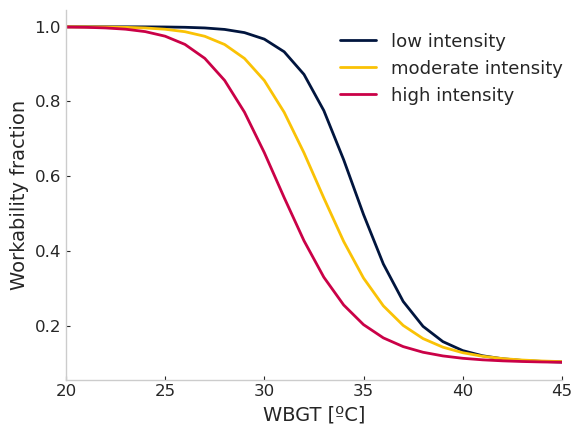

In [126]:
plot_workability_functions()
plt.show()

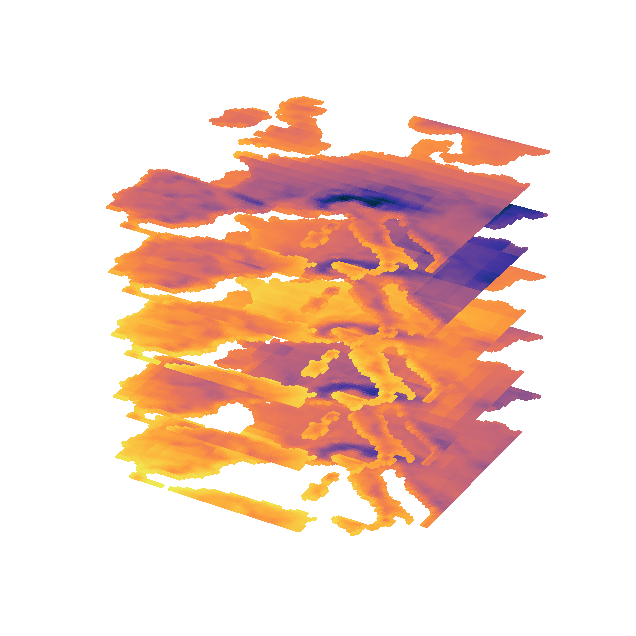

In [167]:
ds = xr.open_zarr('s3://climate-zarr/CMIP6/ScenarioMIP/bias_corrected/DQM/CMIP6-ScenarioMIP_WBGTmean_ssp585.zarr/')

bbox = {
    "lon_min": -10,
    "lon_max": 20,
    "lat_min": 35,
    "lat_max": 60,
}
plot_3d_temperature(ds.isel(time=0).sel(lat=slice(bbox['lat_max'],bbox['lat_min']),lon=slice(bbox['lon_min'],bbox['lon_max'])))

In [ ]:
import cartopy.feature as cfeature
from shapely.geometry import box
from shapely.ops import unary_union
from shapely.vectorized import contains
import cmocean as cmo

def create_land_mask(lon_grid, lat_grid, bbox=None):
    """
    Create a land mask using Natural Earth land geometries.
    
    Parameters:
      lon_grid, lat_grid: 2D numpy arrays representing the meshgrid of longitudes and latitudes.
      bbox: dict or None
          Optional bounding box defined as a dictionary with keys:
          'lon_min', 'lon_max', 'lat_min', 'lat_max'. If provided, the land
          geometry is intersected with this box.
    
    Returns:
      mask: Boolean numpy array with the same shape as lon_grid.
            True indicates a land point; False indicates ocean.
    """
    # Get Natural Earth land feature (110m resolution)
    land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m')
    land_geoms = list(land_feature.geometries())
    land_union = unary_union(land_geoms)
    
    if bbox is not None:
        # Create a bounding box polygon and intersect with the land geometry.
        bbox_poly = box(bbox['lon_min'], bbox['lat_min'], bbox['lon_max'], bbox['lat_max'])
        land_union = land_union.intersection(bbox_poly)
    
    # Create the mask using shapely.vectorized.contains
    mask = contains(land_union, lon_grid, lat_grid)
    return mask

def plot_3d_temperature(ds, z_spacing=20):
    """
    Create a 3D plot with stacked layers for each member_id and mask out ocean regions.
    
    Parameters:
      ds : xarray.Dataset
          Dataset with coordinates 'lat', 'lon', and 'member_id'.
          The variable 'temperature' is assumed to have dimensions 
          ('lat', 'lon', 'member_id').
      z_spacing : float, optional
          Vertical offset between layers (default is 10).
    """
    # Extract coordinate values.
    lats = ds['lat'].values
    lons = ds['lon'].values
    member_ids = ds['member_id'].values

    # Create a meshgrid for lat/lon.
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize temperature for the colormap.
    temp_min = float(ds['WBGTmean'].min().values)+8
    temp_max = float(ds['WBGTmean'].max().values)
    norm = plt.Normalize(temp_min, temp_max)
    cmap = plt.get_cmap('cmo.thermal')

    # Define a bounding box for Western Europe.
    western_europe_bbox = {
        "lon_min": -10,
        "lon_max": 20,
        "lat_min": 35,
        "lat_max": 60,
    }

    # Create a land mask for the grid.
    land_mask = create_land_mask(lon_grid, lat_grid, bbox=western_europe_bbox)

    # Loop over each member_id and plot the corresponding temperature surface.
    for idx, member in enumerate(member_ids):
        # Extract temperature for the current member_id (2D: [lat, lon]).
        temp = ds['WBGTmean'].sel(member_id=member).values

        # Set a vertical offset for this member layer.
        z_offset = idx * z_spacing
        z_layer = np.full_like(lon_grid, z_offset)
        
        # Compute facecolors based on temperature.
        facecolors = cmap(norm(temp))
        # Mask out ocean points: set alpha channel to 0 where land_mask is False.
        facecolors[~land_mask, 3] = 0

        # Plot the surface with the masked facecolors.
        ax.plot_surface(
            lon_grid, lat_grid, z_layer,
            facecolors=facecolors,
            rstride=1, cstride=1, antialiased=True, shade=False
        )
    
    # Set axis labels.
    ax.axis('off')

    plt.show()

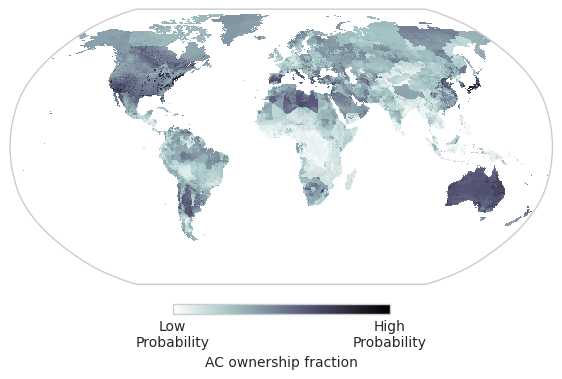

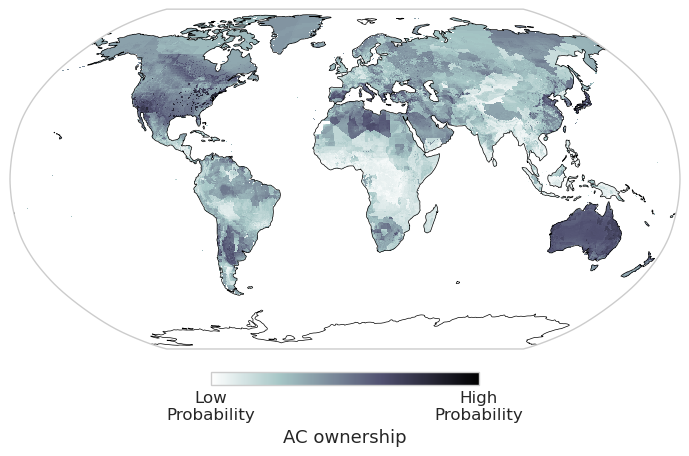

In [217]:
dss = xr.open_zarr('s3://hazard-science-data/productivity_loss_v2/aircon/AirCon_SSPs.zarr/')
dsss = dss.sel(SSP=2,year=2020)

import cartopy.crs as ccrs
with plt.style.context("seaborn-v0_8-whitegrid"):
    f = plt.figure(figsize=(7,5))
    ax = f.add_subplot(111,projection=ccrs.Robinson())
    fg = dsss['ac_penetration'].plot(ax=ax,transform=ccrs.PlateCarree(),cmap='bone_r',cbar_kwargs={'orientation':'horizontal','shrink':0.4,'label':'AC ownership fraction','pad':0.05},vmin=0,vmax=1)
    plt.title('')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Low\nProbability','High\nProbability'],fontsize=12)
    ax.coastlines(lw=0.5)
    cbar.set_label(label='AC ownership', size=13)

    plt.tight_layout()
    plt.show()

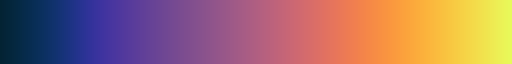

In [163]:
cmap = plt.get_cmap('cmo.thermal')
cmap

In [165]:
plt.get_cmap('d')

ValueError: 'd' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cmo.algae', 'cmo.algae_i', 'cmo.algae_i_r', 'cmo.algae_r', 'cmo.algae_r_i', 'cmo.amp', 'cmo.amp_i', 'cmo.amp_i_r', 'cmo.amp_r', 'cmo.amp_r_i', 'cmo.balance', 'cmo.balance_i', 'cmo.balance_i_r', 'cmo.balance_r', 'cmo.balance_r_i', 'cmo.curl', 'cmo.curl_i', 'cmo.curl_i_r', 'cmo.curl_r', 'cmo.curl_r_i', 'cmo.deep', 'cmo.deep_i', 'cmo.deep_i_r', 'cmo.deep_r', 'cmo.deep_r_i', 'cmo.delta', 'cmo.delta_i', 'cmo.delta_i_r', 'cmo.delta_r', 'cmo.delta_r_i', 'cmo.dense', 'cmo.dense_i', 'cmo.dense_i_r', 'cmo.dense_r', 'cmo.dense_r_i', 'cmo.diff', 'cmo.diff_i', 'cmo.diff_i_r', 'cmo.diff_r', 'cmo.diff_r_i', 'cmo.gray', 'cmo.gray_i', 'cmo.gray_i_r', 'cmo.gray_r', 'cmo.gray_r_i', 'cmo.haline', 'cmo.haline_i', 'cmo.haline_i_r', 'cmo.haline_r', 'cmo.haline_r_i', 'cmo.ice', 'cmo.ice_i', 'cmo.ice_i_r', 'cmo.ice_r', 'cmo.ice_r_i', 'cmo.matter', 'cmo.matter_i', 'cmo.matter_i_r', 'cmo.matter_r', 'cmo.matter_r_i', 'cmo.oxy', 'cmo.oxy_i', 'cmo.oxy_i_r', 'cmo.oxy_r', 'cmo.oxy_r_i', 'cmo.phase', 'cmo.phase_i', 'cmo.phase_i_r', 'cmo.phase_r', 'cmo.phase_r_i', 'cmo.rain', 'cmo.rain_i', 'cmo.rain_i_r', 'cmo.rain_r', 'cmo.rain_r_i', 'cmo.solar', 'cmo.solar_i', 'cmo.solar_i_r', 'cmo.solar_r', 'cmo.solar_r_i', 'cmo.speed', 'cmo.speed_i', 'cmo.speed_i_r', 'cmo.speed_r', 'cmo.speed_r_i', 'cmo.tarn', 'cmo.tarn_i', 'cmo.tarn_i_r', 'cmo.tarn_r', 'cmo.tarn_r_i', 'cmo.tempo', 'cmo.tempo_i', 'cmo.tempo_i_r', 'cmo.tempo_r', 'cmo.tempo_r_i', 'cmo.thermal', 'cmo.thermal_i', 'cmo.thermal_i_r', 'cmo.thermal_r', 'cmo.thermal_r_i', 'cmo.topo', 'cmo.topo_i', 'cmo.topo_i_r', 'cmo.topo_r', 'cmo.topo_r_i', 'cmo.turbid', 'cmo.turbid_i', 'cmo.turbid_i_r', 'cmo.turbid_r', 'cmo.turbid_r_i', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [134]:
ds.isel(time=0).sel(lat=slice(bbox['lat_min'],bbox['lat_max']),lon=slice(bbox['lon_min'],bbox['lon_max']))

<xarray.Dataset> Size: 1kB
Dimensions:    (lat: 0, lon: 42, member_id: 5)
Coordinates:
  * lat        (lat) float64 0B 
  * lon        (lon) float64 336B -8.5 -8.25 -8.0 -7.75 ... 1.0 1.25 1.5 1.75
  * member_id  (member_id) <U50 1kB 'CMCC-ESM2' ... 'EC-Earth3-Veg-LR'
    time       datetime64[ns] 8B 2015-01-01
Data variables:
    WBGTmean   (lat, lon, member_id) float32 0B dask.array<chunksize=(0, 14, 1), meta=np.ndarray>

In [130]:
plt.show()

KeyboardInterrupt: 

In [37]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
from dask.distributed import Client

client = Client()

import s3fs, dask
fs = s3fs.S3FileSystem(anon=False, use_listings_cache=False, asynchronous=True)
dask.config.set(
    {"s3.multipart_chunksize": "50MB"})

In [ ]:
pd.read_csv(fn,encoding='unicode_escape')[['Asset ID']]

In [ ]:
fn = '../data/siemens-energy-ag.csv'
loss_function = 'HOTHAPS'


## read csv  
df_in = pd.read_csv(fn,encoding='unicode_escape')[['Asset ID','Latitude','Longitude','Parent Name','Premise Type','Country']]
df_in = df_in.drop_duplicates('Asset ID').rename(columns={'Latitude':'lat','Longitude':'lon','Country':'country'})
## load asset map 
asset_map = pd.read_csv('../src/asset_map.csv')

## load aircon
aircon = xr.open_zarr('s3://hazard-science-data/productivity_loss_v2/aircon/AirCon_SSPs.zarr/') 
aircon = aircon.sel(SSP='2.0').isel(year=0)['ac_penetration'].chunk(dict(lon=-1)).interpolate_na(method='nearest',dim='lon',limit=3)


## load losses
ds_dict = {}
ds_2020 = {}
for intensity in ['low','moderate','high']:
    ds_2020[intensity] = xr.open_zarr(f's3://hazard-science-data/productivity_loss_v2/climate_outputs/observations/ERA5_{loss_function}_productivity_loss_{intensity}.zarr.zarr/')
for scenario in ['ssp126','ssp245','ssp370','ssp585']:
    ds_dict[scenario] = {}
    for intensity in ['low','moderate','high']:
        ds_dict[scenario][intensity] = xr.open_zarr(f"s3://hazard-science-data/productivity_loss_v2/climate_outputs/projections_corrected/{scenario}/CMIP6-ScenarioMIP_{loss_function}_productivity_loss_{intensity}_{scenario}.zarr.zarr/")

In [ ]:

scenarios = ['ssp585']

# List to accumulate all rows (one per asset_id, year, scenario)
rows_list = []

for scenario in scenarios:
    # Create a temporary copy of your asset data and map work_intensity
    df_temp = df_in.loc[:40, :].copy(deep=True)
    df_temp['work_intensity'] = df_temp['asset_type'].map(asset_map.set_index('asset_type')['intensity'])
    
    # Get the years available for this scenario.
    # Here, we assume the years are the same for every asset in a scenario.
    years = np.concat([[2020],ds_dict[scenario]['high'].year.values])
    stats = ['median', 'minimum', 'maximum']
    
    # Process each asset row
    for _, row in df_temp.iterrows():
        # Get the dataset corresponding to the asset's work intensity in the current scenario
        ds = ds_dict[scenario][row['work_intensity']]
        ds_2020_local = ds_2020[row['work_intensity']].sel(lat=row['lat'], lon=row['lon'], method='nearest')

        # For each year, extract the values for all stats and build a new row
        for year in years:
            row_dict = row.to_dict()  # Copy the asset info (like asset_id, lat, lon, etc.)
            row_dict['scenario'] = scenario
            
            if year == 2020:
                row_dict['year'] = 2020
                for stat in stats:
                    value = np.round(ds_2020_local['median'].values,2)
                    row_dict[stat] = value

            else:
                row_dict['year'] = year
                # Get each statistic value from the dataset (using nearest neighbor)
                for stat in stats:
                    value = np.round(ds.sel(lat=row['lat'], lon=row['lon'], year=year, method='nearest')[stat].values, 2)
                    row_dict[stat] = value
                # Append the new row to our list
            rows_list.append(row_dict)

# Create the final long DataFrame
df_long = pd.DataFrame(rows_list)
df_long.to_csv(f"../output_csvs/unscaled.csv")

In [ ]:
# Make a deep copy of df_long so that the original remains unchanged
df_long_scaled = df_long.copy(deep=True)

# Create a new column for AC_penetration and initialize with NaN
df_long_scaled['AC_penetration'] = np.nan

# Iterate over each row to compute AC penetration and adjust the values
for i in df_long_scaled.index:
    lat = df_long_scaled.loc[i, 'lat']
    lon = df_long_scaled.loc[i, 'lon']
    # Compute AC_penetration using the nearest neighbor from the aircon dataset
    ac_val = np.round(aircon.sel(lat=lat, lon=lon, method='nearest').values, 2)
    df_long_scaled.loc[i, 'AC_penetration'] = ac_val

    # If a valid AC penetration value is found, scale the statistics accordingly
    if not pd.isna(ac_val):
        # Scale 'median', 'minimum', and 'maximum' by multiplying with (1 - AC_penetration)
        df_long_scaled.loc[i, ['median', 'minimum', 'maximum']] *= (1 - ac_val)


In [ ]:
df_long_scaled

In [ ]:
import seaborn as sns 
import random
import matplotlib.pyplot as plt  

In [ ]:

# Define scenarios, e.g., ['ssp126', 'ssp585']
scenarios = ['ssp126','ssp585']

# Select 25 random asset_ids from the entire long-format DataFrame
sample_ids = random.sample(list(df_long_scaled['asset_id'].unique()), 25)

# Create a subplot with one row per scenario
f, ax = plt.subplots(len(scenarios), 1, figsize=(10, 3 * len(scenarios)), sharex=True)

for i, scenario in enumerate(scenarios):
    # Filter for the current scenario, the sampled asset_ids, and only the years 2025 and 2100.
    data = df_long_scaled[
        (df_long_scaled['scenario'] == scenario) &
        (df_long_scaled['asset_id'].isin(sample_ids)) &
        (df_long_scaled['year'].isin([2025, 2100]))
    ].copy()
    
    # Pivot so each asset_id is one row, and columns become "2025_median", "2025_minimum", etc.
    data_pivot = data.pivot(index='asset_id', columns='year', values=['median', 'minimum', 'maximum'])
    # Flatten the MultiIndex columns to single strings.
    data_pivot.columns = [f"{year}_{stat}" for stat, year in data_pivot.columns]
    data_pivot = data_pivot.reset_index()

    # Define x-axis positions for each asset.
    x = np.arange(len(data_pivot))

    # Define error bars for 2025 and 2100.
    err_2025 = [np.abs(data_pivot["2025_median"] - data_pivot["2025_minimum"]),
                np.abs(data_pivot["2025_maximum"] - data_pivot["2025_median"])]
    err_2100 = [np.abs(data_pivot["2100_median"] - data_pivot["2100_minimum"]),
                np.abs(data_pivot["2100_maximum"] - data_pivot["2100_median"])]

    bar_width = 0.4
    # Select the appropriate axis handle.
    a = ax[i] if len(scenarios) > 1 else ax

    # Plot bars with error bars for both years.
    a.bar(x - bar_width / 2, data_pivot["2025_median"], yerr=err_2025, width=bar_width,
          capsize=5, label="2020", color="xkcd:navy")
    a.bar(x + bar_width / 2, data_pivot["2100_median"], yerr=err_2100, width=bar_width,
          capsize=5, label="2100", color="xkcd:ruby")

    a.set_xticks(x)
    a.set_xticklabels(data_pivot['asset_id'], rotation=45,fontsize=6,ha = 'right')
    a.set_ylim(0, 50)
    # a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(scenario)

plt.tight_layout()
plt.show()

In [ ]:

# Define scenarios, e.g., ['ssp126', 'ssp585']
scenarios = ['ssp126','ssp585']

# Select 25 random asset_ids from the entire long-format DataFrame
sample_ids = random.sample(list(df_long_scaled['asset_id'].unique()), 25)

# Create a subplot with one row per scenario
f, ax = plt.subplots(len(scenarios), 1, figsize=(10, 3 * len(scenarios)), sharex=True)

for i, scenario in enumerate(scenarios):
    # Filter for the current scenario, the sampled asset_ids, and only the years 2025 and 2100.
    data = df_long_scaled[
        (df_long_scaled['scenario'] == scenario) &
        (df_long_scaled['asset_id'].isin(sample_ids)) &
        (df_long_scaled['year'].isin([2025, 2100]))
    ].copy()
    
    # Pivot so each asset_id is one row, and columns become "2025_median", "2025_minimum", etc.
    data_pivot = data.pivot(index='asset_id', columns='year', values=['median', 'minimum', 'maximum'])
    # Flatten the MultiIndex columns to single strings.
    data_pivot.columns = [f"{year}_{stat}" for stat, year in data_pivot.columns]
    data_pivot = data_pivot.reset_index()

    # Define x-axis positions for each asset.
    x = np.arange(len(data_pivot))

    # Define error bars for 2025 and 2100.
    err_2025 = [np.abs(data_pivot["2025_median"] - data_pivot["2025_minimum"]),
                np.abs(data_pivot["2025_maximum"] - data_pivot["2025_median"])]
    err_2100 = [np.abs(data_pivot["2100_median"] - data_pivot["2100_minimum"]),
                np.abs(data_pivot["2100_maximum"] - data_pivot["2100_median"])]

    bar_width = 0.4
    # Select the appropriate axis handle.
    a = ax[i] if len(scenarios) > 1 else ax

    # Plot bars with error bars for both years.
    a.bar(x - bar_width / 2, data_pivot["2025_median"], yerr=err_2025, width=bar_width,
          capsize=5, label="2020", color="xkcd:grey")
    a.bar(x + bar_width / 2, data_pivot["2100_median"], yerr=err_2100, width=bar_width,
          capsize=5, label="2100", color="xkcd:black")

    a.set_xticks(x)
    a.set_xticklabels(data_pivot['asset_id'], rotation=45,fontsize=6,ha = 'right')
    a.set_ylim(0.01, 100)
    a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(scenario)

plt.tight_layout()
plt.show()

In [ ]:
ids = random.sample(list(df_long_scaled['asset_id'].unique()),10)
f,ax = plt.subplots(len(ids),1,figsize=(7,2*len(ids)),sharex=True)

colors = {
    'ssp126':'xkcd:navy',
    'ssp245':'xkcd:teal',
    'ssp370':'xkcd:orange',
    'ssp585':'xkcd:ruby'
}

for j,id in enumerate(ids):
    if len(scenarios)>1:
        a = ax[j]
    else:
        a = ax
    

    for i, scenario in enumerate(scenarios):
        y = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['median']
        yhigh = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['maximum']
        ylow = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['minimum']
        x = [2020,2025,2030,2035,2040,2045,2050,2060,2070,2080,2090,2100]

        a.fill_between(x,ylow,yhigh,alpha=0.2,color=colors[scenario])
        a.plot(x,y,color=colors[scenario],label=scenario)
    a.set_ylim(0,np.max(yhigh)+1)
    plt.xlim(2020,2100)
    # a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(id + ' (' + df_long_scaled[(df_long_scaled['asset_id']==id)]['country'].unique() + ')',fontsize=9)
plt.tight_layout()


In [ ]:
id

In [ ]:
y